## CNN: Utilisation d'un modèle VGG 16 préentrainé pour Reconnaissance d'image

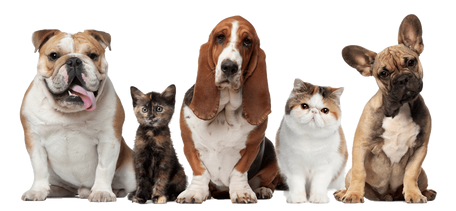


Dans ce Chapitre nous allons voir comment utiliser un réseau CNN **VGG16 déjà entrainé**.
Nous allons également créer une **couche de classification spécifique** à nos données. 

Le modèle VGG 16 que nous allons utiliser est un modèle préentrainé sur des millions d'images de la base imagenet. 

**Les avantages sont multiples** : celà permet de répondre a un problème sur un dataset spécifique sans partir de zero et d'autre part les temps d'entrainement sont également bien plus court qu'un modèle complet.

Dans l'exemple présenté le modèle pourrait réussir sans doute trés bien pour la reconnaissance de chien/chat sans entrainement spécifique.
Cependant nous allons voir comment reprendre ce type de réseau et de mettre en oeuvre un entrainement sur un classifieur spécifique à nos jeux de données.

A noter que pour changer nous allons cette fois utiliser les librairies Keras **inclues** de tensorflow (et non les lib spécifiques). 
Ce point mérite d'être souligné car la syntaxe de la construction du réseau sera légerement différente des deux précédents chapitres.

Nous allons également revoir et **approfondir certaines notions** vues dans les précédents chapitres.

Références:
https://github.com/aidiary/keras-examples/blob/master/vgg16/17flowers/finetuning_with_preprocess.py
https://github.com/aditya9898/transfer-learning/blob/master/transfer-learning.py
http://cs231n.github.io/convolutional-networks/

### Architecture du modèle VGG16

Le modèle présenté ci-dessous est un modèle de réseau CNN proposé par K. Simonyan et A. Zisserman de l'université d'Oxford.
Il permet d'atteindre 92.7% sur la banque de données ImageNet qui contient **14 Millions d'image appartenant à 1000 classes**.


Dans ce modèle nous n'allons pas utiliser la couche de classification du VGG16 mais nous allons ajouter et **entrainer notre propre classifier**, spécifique à la résponse au problème de nos propres données.


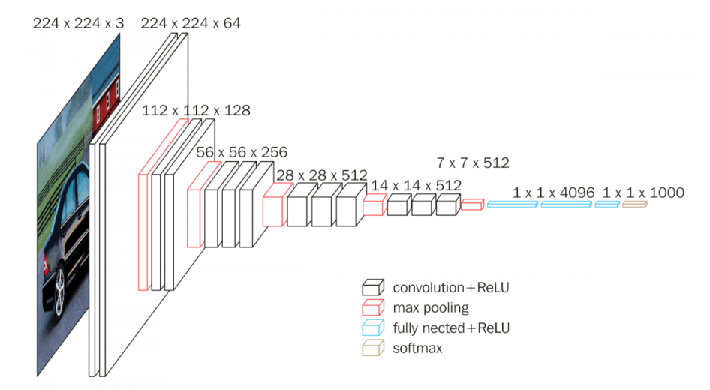

L'image en entrée à une taille de 224 * 224 * 3(RVB). Les 3 dimensions étant les couches RVB constituant les images.

Ensuite les layers de convolution de par leur méchanisme créent un ensemble de couches supplémentaires (features) qui "augmentent" les dimensions de l'image (épaisseur) en ajoutant les résultats des filtres de convolution. 

La couche de pooling réduit la largeur/hauteur de l'image. 

Au final avant la couche entièrement connectée nous avons une image très épaisse mais trés petite.

Un rapide calcul montre qu'il y a 224 * 224 * 3 = 150 528 pixels en entrée pour 1 835 008 en sortie ( 7 * 7 * 512). 

En passant cette partie d'extraction de features du réseau "l'image" résultante s'est donc enrichie en information.

**Exemple de filtres de convolution:
**
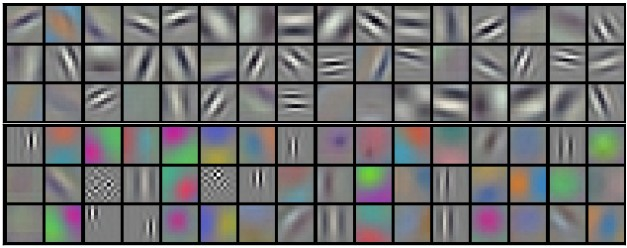

## Passons à l'implémentation !

In [ ]:
# ---------------------------------------------------------------------------
# Import des librairies
# ---------------------------------------------------------------------------

# librairies communes
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librairies tensorflow
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# ---------------------------------------------------------------------------
# Configuration des paramètres principaux du modèle
# ---------------------------------------------------------------------------
# Le chemin vers la sauvegarde du réseau
model_savepath    = 'cnn_vgg16_model_trained_2.h5'     

# Les chemins vers les jeu de données
TRAINING_DIR      = '../input/dogs-vs-cats-redux-kernels-edition/train'
TESTING_DIR       = '../input/dogs-vs-cats-redux-kernels-edition/test'

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 22     # nombre d'epoch 
BATCH_SIZE    = 16     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 15     # pour un VGG16 freeze de réapprentissage de certaines couches
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

### Préparation des jeux de données

Ces étapes sont similaires à celles vues dans le cours précédent, n'hésitez pas à vous y reporter.

#### Rappel Split Train / Validation

Nous allons comme d'habitude commencer par la préparation des jeux de données permettant d'entrainer notre réseau. 

Pour celà nous allons splitter dans un ratio 80/20% les images permettant l'apprentissage et les images permettant la validation.

Le modèle va donc apprendre sur le jeu d'entrainement puis valider les prédictions sur le jeu de validation.
A noter que ces deux jeux de données sont labellisés : c'est à dire que l'on connait les classes auquelles appartiennent les images

Le schéma suivant donne une illustration de la répartition entre le jeu d'entrainement et le jeu de validation: 


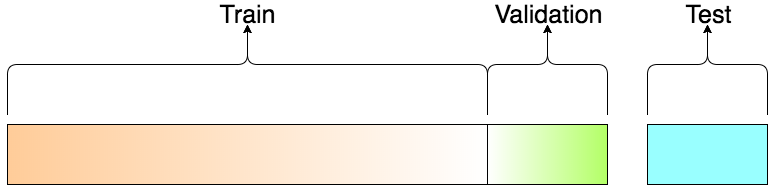

In [ ]:
# ---------------------------------------------------------------------------
#  Constitution des jeux de données
# ---------------------------------------------------------------------------    

# -------
#  Jeu d'entrainement
# -------

# Dataframe de deux colonnes contenant les id des fichiers et leur label
train_files = os.listdir(TRAINING_DIR)
train_labels = []

for file in train_files:
    train_labels.append(file.split(".")[0])

df_train = pd.DataFrame({"id": train_files, "label": train_labels})


Pour donner une illustration du Dataframe que nous obtenons donc 2 colonnes :
1. id avec le nom du fichier
2. label avec la catégorie de l'image

In [ ]:
df_train.head()

Nous allons maintenant parcourir toutes les images pour le **jeu d'entrainement** gràace à une librairie Keras.

Nous spécifions 80% pour le jeu d'entrainement (Il faut veiller à appeler le subset: training)

**Fonctionnement du générateur** : pour préciser de façon synthétique le mode de fonctionnement : le générateur va aller ouvrir chaque image sous forme d'un tableau de 3 dimensions (numpy array) puis lui appliquer une fonction de traitement (preprocess_input) spécifique au réseau VGG16 dans notre cas. Nous ne devons pas utiliser d'autres transformations d'augmentation car le réseau VGG16 se comporte mal dans ce cas (c'est un réseau déjà pré-entrainé)

L'image sera labellisée avec la colonne 'label' pour permettre l'apprentissage supervisé.

In [ ]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.20)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')

train_labels = to_categorical(train_generator.classes)

Même chose pour le **jeu de validation** à la seule différence du nom du subset : validation

In [ ]:
# -------
#  Jeu de validation
# -------

valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='validation',
            class_mode='categorical')

Pour le jeu de test c'est un peu différent : on précise class_mode et y_col à None car nous n'avons pas de label.
Nous mettons batch size à 1.

In [ ]:
# -------
# Jeu de test
# -------

test_files = os.listdir(TESTING_DIR)
df_test = pd.DataFrame({"id": test_files, 'label': 'nan'})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)    
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        has_ext=True, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

## Combinaison du VGG16 et de notre classifier
C'est dans cette étape que nous utilisons le réseau VGG16 en ajoutant notre **propre couche de classification**. 

Cette couche FC (entièrement connectée) est un réseau de neurones classique qui va permettre à partir de la sortie du VGG16 de faire une prédiction. 

Sa couche de sortie contient n neurones (n représentant le nombre de classes que nous souhaitons prédire) dans ce cas : 2.

Commençons par déclarer le réseau qui va nous servir de **modèle de base** :

In [ ]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------

# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model = VGG16(include_top=False, weights=None, input_tensor=None,
            input_shape=(IMGSIZE, IMGSIZE, 3))

# Chargement des points préentrainés du modèle
# Dataset = Full Keras Pretrained No Top
base_model.load_weights('../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

**Détails sur le Classifier**

Nous ajoutons la **couche de classification** (Top Layer) sur le réseau de Convolution:
* applatissement de l'image de sortie en un vecteur
* ajout de 2 couches de 128 neurones
* ajout d'une couche de régularisation pour éviter l'overfitting
* ajour de la couche de sortie à deux neurones pour la prédiction (probabilistique)

Cette couche effectue la **decente de gradient** pour le calcul numérique de l'optimisation de la fonction de coût
* **le feed forward** des input vers la couche de sortie
* **la backpropagation** en fonction de l'erreur de prédiction

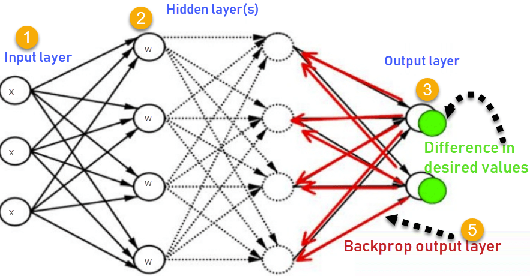

L'image ci-dessus représente le classifier. L'entrée du classifier est un vecteur applati issue de la sortie du modèle de convolution pour chaque image.

In [ ]:
# Classifier
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dropout(0.3)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(2, activation='softmax', name='softmax')(x)

**Assemblage du modèle final**

Cette étape permet simplement d'ajouter notre couche de sortie sur le modèle CNN.
Nous nous occupons aussi de **Freezer certaines couches** du modèles pour ne pas qu'elles soient réentrainées.

In [ ]:
# Assemblage du modèle final
net_final = Model(inputs=base_model.input, outputs=output_layer)

# freeze de certains layers (spécifique au modèle utilisé)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
    
# Entrainement des derniers layers de classification
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# compilation du modele
net_final.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

In [ ]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size

## Entrainement du modèle : régression logistique
Nous sommes rendus à l'étape ou nous pouvons entrainer notre modèle.

Les librairies de keras fit_generator vont donc effectuer la partie de descente de gradient pour optimiser la fonction de cout du réseau.
Comme nous sommes dans une problèmatique de classification c'est la régression logistique qui va être mise en oeuvre, détail de l'équation ci-dessous:

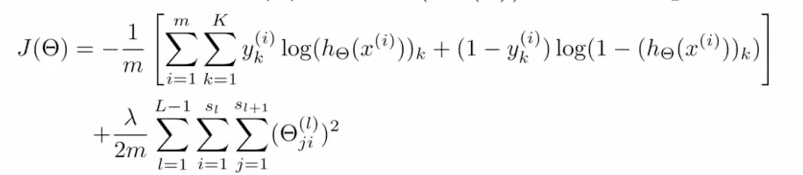

Cette équation présente la fonction de **coût de la regression logistique** que le réseau cherche à optimiser. Tous les calculs numériques sont inclues dans les librairies que nous utilisons, c'est pourquoi nous n'avons rien à faire, l'algorithme est déjà implémenté et optimisé.

In [ ]:
if (TRAIN):
    
    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    checkpoint = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    #   pour arrêt prématuré
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
    history = net_final.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [checkpoint, early],
                    epochs = EPOCH)
    
    # Sauvegarde du réseau après entrainement
    net_final.save(model_savepath)    
    
else:
    net_final.load_weights('../input/cnn-vgg16-model-trained-2/cnn_vgg16_model_trained_2/'+model_savepath)   


In [ ]:
# --------------------------------------
# Affichage des courbes accuracy et Loss
# --------------------------------------
if (TRAIN):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

## Génération des prédictions
Maintenant que notre modèle est entrainé nous allons pouvoir l'évaluer et lui demander de faire les prédictions sur nos images de tests

In [ ]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = net_final.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

In [ ]:
# Affichage des classes du jeu d'entrainement
train_generator.class_indices

In [ ]:
# Génération des prédictions
test_generator.reset()
pred = net_final.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

In [ ]:
# La colonne 1 représente la probabilité que l'image soit un chien (la colonne 0 que l'image soit un chat)
pred[:,1]

In [ ]:
# Enregistrement fichier soumission
soumission=pd.DataFrame({"id":test_generator.filenames,"label":pred[:,1]})
soumission['id'] = soumission['id'].str[:-4].astype('int')
soumission = soumission.sort_values(by=['id'])
soumission.to_csv('soumission.csv', index=False)

In [ ]:
# ---------------------------------------------------------
# Affichage aléatoires images prédites 0 = chat / 1 = chien
# ---------------------------------------------------------
import random

n = soumission.shape[0]
f = list(np.arange(1,n))

c = 20
r =random.sample(f, c)
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*5, ncols*5))    
for i in range(c):
    file = str(soumission['id'][r[i]]) + '.jpg'
    path = TESTING_DIR + "/" + file
    img = plt.imread(path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img, aspect='auto')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(soumission['id'][r[i]])+"\n"+str(soumission['label'][r[i]]))
plt.show()